## Dissecting baseComcamLoop.py

### Motivation 

A notebook to understand how does `baseComcamLoop.py` work in detail, including all the dependencies on `ts_wep`, `ts_ofc`  and `ts_phosim`.  We need to be able to describe how the feedback loop is run, including all the creation of all  output directories  to make the `star_separation_test.ipynb`.

In [ ]:
import os
import argparse
import numpy as np
import shutil

from lsst.ts.wep.ParamReader import ParamReader
from lsst.ts.wep.Utility import FilterType, CamType, runProgram
from lsst.ts.wep.ctrlIntf.WEPCalculationFactory import WEPCalculationFactory
from lsst.ts.wep.ctrlIntf.RawExpData import RawExpData

from lsst.ts.ofc.Utility import InstName
from lsst.ts.ofc.ctrlIntf.OFCCalculationFactory import OFCCalculationFactory

from lsst.ts.phosim.telescope.TeleFacade import TeleFacade
from lsst.ts.phosim.PhosimCmpt import PhosimCmpt
from lsst.ts.phosim.SkySim import SkySim
from lsst.ts.phosim.Utility import getPhoSimPath, getAoclcOutputPath, \
                                   getConfigDir
from lsst.ts.phosim.PlotUtil import plotFwhmOfIters


In [ ]:
import numpy

In [4]:
!which python

/astro/store/epyc/projects/lsst_comm/new_stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/bin/python


In [2]:

from lsst.ts.wep.ParamReader import ParamReader

ModuleNotFoundError: No module named 'lsst'

`baseComcamLoop.py` is run in the following manner inside `runStarSeparationAnalysis.py` : 
    

Setting the starCat.txt : 

In [2]:
phosimDir = getPhoSimPath() 
outputDir = getAoclcOutputPath()
testLabel = 'sep'
skyFilePath  = 'starCat.txt'

In [3]:
testOutputDir = '/data/epyc/users/suberlak/Commissioning/aos/aoclc_analysis/'
os.environ["closeLoopTestDir"] = testOutputDir

In [4]:
def _eraseFolderContent(targetDir):

    for theFile in os.listdir(targetDir):
        filePath = os.path.join(targetDir, theFile)
        if os.path.isfile(filePath):
            os.unlink(filePath)
        elif os.path.isdir(filePath):
            shutil.rmtree(filePath)

_eraseFolderContent(outputDir)

In [5]:
import os
import sys
sys.path.append('../analysis_scripts//')


In [6]:
from createPhosimCatalog import createPhosimCatalog

#skyFilePath points to a phosim star catalog file : starCat.txt 

numPro = 30 # number of processors setting in phosimCmptSetting.yaml 
iterNum  = 1 # number of iterations 
starSep = 0.05 # star separation over which we are looping 
    
createCat = createPhosimCatalog()
raShiftPx = 150
decShiftPx = 150
raShift = (raShiftPx * .2) / 3600 # Convert to degrees
decShift = (decShiftPx * .2) / 3600 # Convert to degrees


# read the star brightness
magVal   = 16

createCat.createPhosimCatalog(2, starSep, [magVal,magVal], raShift, decShift,
                              skyFilePath)


'''
    ccLoop.main(phosimDir, numPro, 1, outputDir, '%s.%.1f' % (testLabel, starSep), 
                    isEimg=False, genOpd=True, genDefocalImg=True, 
                    genFlats=True, useMinDofIdx=False,
                    inputSkyFilePath=skyFilePath, m1m3ForceError=0.05)
'''

"\n    ccLoop.main(phosimDir, numPro, 1, outputDir, '%s.%.1f' % (testLabel, starSep), \n                    isEimg=False, genOpd=True, genDefocalImg=True, \n                    genFlats=True, useMinDofIdx=False,\n                    inputSkyFilePath=skyFilePath, m1m3ForceError=0.05)\n"

The signature of that function is the following : 

In [20]:
'''class baseComcamLoop():

    def main(self, phosimDir, numPro, iterNum, baseOutputDir, 
            testName, isEimg=False, genOpd=True, genDefocalImg=True, genFlats=True,
            surveyFilter=None, starMag=15, 
            useMinDofIdx=False, inputSkyFilePath="", m1m3ForceError=0.05):
'''

'class baseComcamLoop():\n\n    def main(self, phosimDir, numPro, iterNum, baseOutputDir, \n            testName, isEimg=False, genOpd=True, genDefocalImg=True, genFlats=True,\n            surveyFilter=None, starMag=15, \n            useMinDofIdx=False, inputSkyFilePath="", m1m3ForceError=0.05):\n'

In [ ]:
more 

This means that the arguments passed to baseComcamLoop are : 
    


In [7]:
baseOutputDir = outputDir
testName = '%s.%.1f' % (testLabel, starSep)
isEimg=False; genOpd=True; genDefocalImg=True; genFlats=True; useMinDofIdx=False
surveyFilter=None
inputSkyFilePath=skyFilePath
m1m3ForceError=0.05

In [8]:
baseOutputDir

'/epyc/users/suberlak/Commissioning/aos/aoclc_output/'

The beginning of baseComcamLoop main  :

In [9]:
# Prepare the calibration products (only for the amplifier images)
#sensorNameList = self._getComCamSensorNameList()
sensorNameList = ["R22_S00", "R22_S01", "R22_S02", "R22_S10", "R22_S11",
                        "R22_S12", "R22_S20", "R22_S21", "R22_S22"]


if ((not isEimg) & (genFlats is True)): # pass by default 
    #fakeFlatDir = self._makeCalibs(baseOutputDir, sensorNameList) : 
    # begin self._makeCalibs :
    outputDir = baseOutputDir
    fakeFlatDirName = "fake_flats"
    fakeFlatDir = os.path.join(outputDir, fakeFlatDirName)
    
    ## self._makeCalibs calls self._makeDir(fakeFlatDir) : 
    ## begin self._makeDir
    if (not os.path.exists(fakeFlatDir)):
            os.makedirs(fakeFlatDir)
    ## end self._makeDir
    
    # back to self._makeCalibs
    detector = " ".join(sensorNameList)
    #self._makeCalibs calls  self._genFakeFlat(fakeFlatDir, detector) : 
    
    ## begin self._genFakeFlat
    currWorkDir = os.getcwd()
    os.chdir(fakeFlatDir)
    ## self._genFakeFlat calls self._makeFakeFlat(detector)
    
    ### begin self._makeFakeFlat
    command = "makeGainImages.py"
    argstring = "--detector_list %s" % detector
    runProgram(command, argstring=argstring)
    ### end self._makeFakeFlat
    
    # back to self._genFakeFlat
    os.chdir(currWorkDir)

    # return fakeFlatDir
    # end self._makeCalibs
    
    
# Make the ISR directory
isrDirName = "input"
isrDir = os.path.join(baseOutputDir, isrDirName)
if genFlats is True:
    ## self.main  calls self._makeDir(isrDir) : 
    ## begin self._makeDir
    if (not os.path.exists(isrDir)):
            os.makedirs(isrDir)
    ## end self._makeDir

In [10]:
# Survey parameters
surveySettingFilePath = os.path.join(getConfigDir(),
                                    "surveySettings.yaml")
surveySettings = ParamReader(filePath=surveySettingFilePath)


# eg. surveyFilter= 'r' - that would simulate stars in different filters 
if surveyFilter is None:
    filterType = FilterType.fromString(surveySettings.getSetting("filterType"))
else:
    filterType = FilterType.fromString(surveyFilter)
raInDeg = surveySettings.getSetting("raInDeg")
decInDeg = surveySettings.getSetting("decInDeg")
rotAngInDeg = surveySettings.getSetting("rotAngInDeg")

Now `self.main()` calls  `self._preparePhosimCmpt()`:

In [11]:
# Prepare the components
# self.main calls phosimCmpt = self._preparePhosimCmpt(phosimDir, filterType, raInDeg, decInDeg,
#                                rotAngInDeg, numPro, isEimg, m1m3ForceError)

# whose signature is _preparePhosimCmpt(self, phosimDir, filterType, raInDeg, decInDeg, rotAngInDeg,
#                       numPro, isEimg, m1m3ForceError)

# so the params passed are called the same way 

# begin self._preparePhosimCmpt:

# Set the Telescope facade class
tele = TeleFacade()
tele.addSubSys(addCam=True, addM1M3=True, addM2=True)
tele.setPhoSimDir(phosimDir)

In [12]:
# now the AnalysisPhoSimCmpt() is instantiated, so need to define it : 

class AnalysisPhosimCmpt(PhosimCmpt):

    def _writeOpdZkFile(self, zkFileName, rotOpdInDeg):
        """Write the OPD in zk file.
        OPD: optical path difference.
        Parameters
        ----------
        zkFileName : str
            OPD in zk file name.
        rotOpdInDeg : float
            Rotate OPD in degree in the counter-clockwise direction.
        """

        testOutputDir = os.environ["closeLoopTestDir"]
        filePath = os.path.join(testOutputDir, zkFileName)
        opdData = self._mapOpdToZk(rotOpdInDeg)
        header = "The followings are OPD in rotation angle of %.2f degree in um from z4 to z22:" % (
            rotOpdInDeg)
        np.savetxt(filePath, opdData, header=header)

    def reorderAndSaveWfErrFile(self, listOfWfErr, refSensorNameList,
                                zkFileName="wfs.zer"):
        """Reorder the wavefront error in the wavefront error list according to
        the reference sensor name list and save to a file.
        The unexisted wavefront error will be a numpy zero array. The unit is
        um.
        Parameters
        ----------
        listOfWfErr : list [lsst.ts.wep.ctrlIntf.SensorWavefrontData]
            List of SensorWavefrontData object.
        refSensorNameList : list
            Reference sensor name list.
        zkFileName : str, optional
            Wavefront error file name. (the default is "wfs.zer".)
        """

        # Get the sensor name that in the wavefront error map
        wfErrMap = self._transListOfWfErrToMap(listOfWfErr)
        nameListInWfErrMap = list(wfErrMap.keys())

        # Reorder the wavefront error map based on the reference sensor name
        # list.
        reorderedWfErrMap = dict()
        for sensorName in refSensorNameList:
            if sensorName in nameListInWfErrMap:
                wfErr = wfErrMap[sensorName]
            else:
                numOfZk = self.getNumOfZk()
                wfErr = np.zeros(numOfZk)
            reorderedWfErrMap[sensorName] = wfErr

        # Save the file
        testOutputDir = os.environ["closeLoopTestDir"]
        filePath = os.path.join(testOutputDir, zkFileName)
        wfsData = self._getWfErrValuesAndStackToMatrix(reorderedWfErrMap)
        header = "The followings are ZK in um from z4 to z22:"
        np.savetxt(filePath, wfsData, header=header)


# Prepare the phosim component
phosimCmpt = AnalysisPhosimCmpt(tele)

# Set the telescope survey parameters
boresight = (raInDeg, decInDeg)
zAngleInDeg = 27.0912
phosimCmpt.setSurveyParam(filterType=filterType, boresight=boresight,
                        zAngleInDeg=zAngleInDeg, rotAngInDeg=rotAngInDeg)

# Update the setting file if needed
settingFile = phosimCmpt.getSettingFile()
if (numPro > 1):
    settingFile.updateSetting("numPro", numPro)
if isEimg: # isEimg = False by default 
    settingFile.updateSetting("e2ADC", 0)

# Set the seed number for M1M3 surface
seedNum = 6
phosimCmpt.setSeedNum(seedNum)

# Set the M1M3 force error
phosimCmpt.setM1M3ForceError(m1m3ForceError)




In [71]:
settingFile.getFilePath()

'/data/epyc/users/suberlak/Commissioning/aos/ts_phosim/policy/phosimCmptSetting.yaml'

In [73]:
!more /data/epyc/users/suberlak/Commissioning/aos/ts_phosim/policy/phosimCmptSetting.yaml

---

# PhoSim component setting

# Number of zk (annular Zernike polynomials) terms
numOfZk: 19

# Intra-focal directory name. This is needed if the defocal image is by the
# camera piston.
intraDirName: intra

# Extra-focal directory name. This is needed if the defocal image is by the
# camera piston.
extraDirName: extra

# PhoSim-related default parameters

# Number of processors. The value should be >= 1.
numPro: 1

# Whether to generate amplifier images (1 = true, 0 = false)
e2ADC: 1


Back to `self.main()` (line 121): 
    
    




In [13]:
# self.main() calls  wepCalc = self._prepareWepCalc(isrDir, filterType, raInDeg, decInDeg,
#                        rotAngInDeg, isEimg)

# whose signature is 
# _prepareWepCalc(self, isrDirPath, filterType, raInDeg, decInDeg, rotAngInDeg,
#                        isEimg)

# so the params are passed without name change apart from :
isrDirPath = isrDir

# begin self._prepareWepCalc()

wepCalc = WEPCalculationFactory.getCalculator(CamType.ComCam, isrDirPath)
wepCalc.setFilter(filterType)
wepCalc.setBoresight(raInDeg, decInDeg)
wepCalc.setRotAng(rotAngInDeg)

if (isEimg): # False by default 
    settingFile = wepCalc.getSettingFile()
    settingFile.updateSetting("imageType", "eimage")
            
# end self._prepareWepCalc()

# back to self.main() 
tele = phosimCmpt.getTele()
defocalDisInMm = tele.getDefocalDistInMm()
wepCalc.setDefocalDisInMm(defocalDisInMm)

# self.main() calls 
# ofcCalc = self._prepareOfcCalc(filterType, rotAngInDeg)
# begin self._prepareOfcCalc()
ofcCalc = OFCCalculationFactory.getCalculator(InstName.COMCAM)
ofcCalc.setFilter(filterType)
ofcCalc.setRotAng(rotAngInDeg)
ofcCalc.setGainByPSSN()
# end self._prepareOfcCalc()

In [14]:
# Ingest the calibration products (only for the amplifier images)
if ((not isEimg) & (genFlats is True)):
    wepCalc.ingestCalibs(fakeFlatDir)

# Only use 10 hexapod positions and first 3 bending modes of M1M3 and M2
if (useMinDofIdx): # this is false 
    self._useMinDofIdx(ofcCalc)

# Set the telescope state to be the same as the OFC
state0 = ofcCalc.getStateAggregated()
phosimCmpt.setDofInUm(state0)

## Run one iteration

In [15]:
# Do the iteration
obsId = 875641
opdZkFileName = str("opd.zer" + '.' + testName)
wfsZkFileName = str("wfs.zer" + '.' + testName)
opdPssnFileName = "PSSN.txt"
outputDirName = "pert"
outputImgDirName = "img" 
iterDefaultDirName = "iter"
dofInUmFileName = "dofPertInNextIter.mat"
skyInfoFileName = "skyComCamInfo.txt"



In [16]:
iterNum = 1 
iterCount = 0
#for iterCount in range(iterNum):

#### beginning of iteration 

# Set the observation Id
phosimCmpt.setSurveyParam(obsId=obsId)

# The iteration directory
iterDirName = "%s%d" % (iterDefaultDirName, iterCount)

# Set the output directory
outputDir = os.path.join(baseOutputDir, iterDirName, outputDirName)
phosimCmpt.setOutputDir(outputDir)

# Set the output image directory
outputImgDir = os.path.join(baseOutputDir, iterDirName,
                            outputImgDirName)
phosimCmpt.setOutputImgDir(outputImgDir)




### Generate the OPD image

In [130]:
prepend = 'w $AOCLCOUTPUTPATH'
a =  'sdsd'

prepend+' '+a

'w $AOCLCOUTPUTPATH sdsd'

In [131]:

# Generate the OPD image
if genOpd is True:
    argString = phosimCmpt.getComCamOpdArgsAndFilesForPhoSim()
    
    # add that path to phosim : 
    argString = '-w $AOCLCOUTPUTPATH ' + argString
    phosimCmpt.runPhoSim(argString)
    
    

KeyboardInterrupt: 

/epyc/users/suberlak/Commissioning/aos/aoclc_output/iter0/pert/starExtra.inst -i lsst -e 1 -c /epyc/users/suberlak/Commissioning/aos/aoclc_output/iter0/pert/star.cmd -p 40 -o /epyc/users/suberlak/Commissioning/aos/aoclc_output/iter0/img/extra > /epyc/users/suberlak/Commissioning/aos/aoclc_output/iter0/img/extra/starExtraPhoSim.log 2>&1

python /astro/store/epyc/projects/lsst_comm/phosim_syseng4/phosim.py -w $AOCLCOUTPUTPATH /epyc/users/suberlak/Commissioning/aos/aoclc_output/iter0/pert/starExtra.inst -i lsst -e 1 -c /epyc/users/suberlak/Commissioning/aos/aoclc_output/iter0/pert/star.cmd -p 8 -o /epyc/users/suberlak/Commissioning/aos/aoclc_output/iter0/img/extra

Note:  when running `python baseComcamLoop.py`, the `testOutput=""`, so it sets it to `os.path.realpath(__file__)`, where `__file__` points to the file currently executed by python 

In [19]:
testOutput = '/data/epyc/users/suberlak/Commissioning/aos/aoclc_analysis/'

In [20]:
#testOutput = outputDir # just for now .. 
if (testOutput == ""):
    testOutputDir = os.path.dirname(os.path.realpath(__file__))
else:
    testOutputDir = testOutput


os.environ["closeLoopTestDir"] = testOutputDir

# Analyze the OPD data
phosimCmpt.analyzeComCamOpdData(zkFileName=opdZkFileName,
                                pssnFileName=opdPssnFileName)

In [21]:
# Get the PSSN from file
pssn = phosimCmpt.getOpdPssnFromFile(opdPssnFileName)
print("Calculated PSSN is %s." % pssn)

# Get the GQ effective FWHM from file
gqEffFwhm = phosimCmpt.getOpdGqEffFwhmFromFile(opdPssnFileName)
print("GQ effective FWHM is %.4f." % gqEffFwhm)

# Set the FWHM data
listOfFWHMSensorData = phosimCmpt.getListOfFwhmSensorData(
    opdPssnFileName, sensorNameList)
ofcCalc.setFWHMSensorDataOfCam(listOfFWHMSensorData)

Calculated PSSN is [0.59515269 0.59006253 0.59086933 0.59333341 0.58535632 0.58658711
 0.59610244 0.58819379 0.58696264].
GQ effective FWHM is 0.5429.


In [22]:
# Prepare the faked sky - this is skipped because inputSkyFilePath = 'starCat.txt'
if (inputSkyFilePath == ""):
    # According to the OPD field positions
    metr = phosimCmpt.getOpdMetr()
    skySim = self._prepareSkySim(metr, starMag)
    print("Use the default OPD field positions to be star positions.")
    print("The star magnitude is chosen to be %.2f." % starMag)
else:
    # self.main() calls skySim = self._prepareSkySimBySkyFile(inputSkyFilePath)
    # begin self._prepareSkySimBySkyFile
    skySim = SkySim()
    absSkyFilePath = os.path.abspath(inputSkyFilePath)
    skySim.addStarByFile(absSkyFilePath)
    # end self._prepareSkySimBySkyFile


In [21]:
absSkyFilePath


'/data/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_notebooks/starCat.txt'

In [22]:
!ls /astro/store/epyc/projects/lsst_comm/aoclc_output/iter0/pert



M1M3zlist.txt  M2res.txt    opd.cmd	     skyComCamInfo.txt
M1res.png      M2zlist.txt  opd.inst	     star.cmd
M1res.txt      M3res.png    opd.zer.sep.0.1  starExtra.inst
M2res.png      M3res.txt    pert.cmd	     starIntra.inst


In [87]:
outputSkyInfoFilePath

'/epyc/users/suberlak/Commissioning/aos/aoclc_output/iter0/pert/skyComCamInfo.txt'

In [88]:
# Output the sky information
# self.main() calls skySim, wepCalc = self._outputSkyInfo(outputDir, skyInfoFileName, skySim, wepCalc)

# begin self._outputSkyInfo
outputSkyInfoFilePath = os.path.join(outputDir, skyInfoFileName)
skySim.exportSkyToFile(outputSkyInfoFilePath)
wepCalc.setSkyFile(outputSkyInfoFilePath)
# end self._outputSkyInfo 


# Assign the entra- and intra-focal observation Id
extraObsId = obsId + 1
intraObsId = obsId + 2

### Generate the defocal image

In [24]:
# Generate the defocal images
simSeed = 1000
argStringList = phosimCmpt.getComCamStarArgsAndFilesForPhoSim(extraObsId, intraObsId, skySim, simSeed=simSeed,
    cmdSettingFileName="starDefault.cmd", instSettingFileName="starSingleExp.inst")
if genDefocalImg is True:
    for argString in argStringList:
        phosimCmpt.runPhoSim(argString)

    # Repackage the images based on the image type
    if (isEimg):
        phosimCmpt.repackageComCamEimgFromPhoSim()
    else:
        phosimCmpt.repackageComCamAmpImgFromPhoSim()

These are the commands run by phosim: 

In [25]:
argStringList

['/epyc/users/suberlak/Commissioning/aos/aoclc_output/iter0/pert/starExtra.inst -i lsst -e 1 -c /epyc/users/suberlak/Commissioning/aos/aoclc_output/iter0/pert/star.cmd -p 30 -o /epyc/users/suberlak/Commissioning/aos/aoclc_output/iter0/img/extra > /epyc/users/suberlak/Commissioning/aos/aoclc_output/iter0/img/extra/starExtraPhoSim.log 2>&1',
 '/epyc/users/suberlak/Commissioning/aos/aoclc_output/iter0/pert/starIntra.inst -i lsst -e 1 -c /epyc/users/suberlak/Commissioning/aos/aoclc_output/iter0/pert/star.cmd -p 30 -o /epyc/users/suberlak/Commissioning/aos/aoclc_output/iter0/img/intra > /epyc/users/suberlak/Commissioning/aos/aoclc_output/iter0/img/intra/starIntraPhoSim.log 2>&1']

The defocal images created by the above are in:

In [74]:
outputImgDir

'/epyc/users/suberlak/Commissioning/aos/aoclc_output/iter0/img'

In particular, intrafocal are in `outputImgDir + phosimCmpt.getIntraFocalDirName()`, i.e. 

In [77]:
intraRawExpDir

'/epyc/users/suberlak/Commissioning/aos/aoclc_output/iter0/img/intra'

and extrafocal are in 

In [78]:
extraRawExpDir

'/epyc/users/suberlak/Commissioning/aos/aoclc_output/iter0/img/extra'

### Collect the defocal images

In [89]:
# Collect the defocal images
intraRawExpData = RawExpData()
intraRawExpDir = os.path.join(outputImgDir,
                            phosimCmpt.getIntraFocalDirName())
intraRawExpData.append(intraObsId, 0, intraRawExpDir)

extraRawExpData = RawExpData()
extraRawExpDir = os.path.join(outputImgDir,
                            phosimCmpt.getExtraFocalDirName())
extraRawExpData.append(extraObsId, 0, extraRawExpDir)


### Calculate the wavefront error and DOF

We tried inserting this line to clear the db handle, but perhaps need to do it some other way ... 

In [90]:
mappedFilterType

<FilterType.G: 2>

In [91]:
# Delete old db 
sourSelc =  wepCalc.wepCntlr.getSourSelc()
sourSelc.db.deleteTable(mappedFilterType)

ProgrammingError: Cannot operate on a closed cursor.

In [82]:
# Calculate the wavefront error and DOF  (line 235) 
listOfWfErr = wepCalc.calculateWavefrontErrors(intraRawExpData, extraRawExpData=extraRawExpData)



RuntimeError: Error running: runIsr.py /epyc/users/suberlak/Commissioning/aos/aoclc_output/input --id --rerun=run1 --configfile /epyc/users/suberlak/Commissioning/aos/aoclc_output/input/isr_config.py

Note: the config file the error refers to is 

In [83]:
!more /epyc/users/suberlak/Commissioning/aos/aoclc_output/input/isr_config.py

config.isr.doBias=False
config.isr.doDark=False
config.isr.doFlat=True
config.isr.doFringe=False
config.isr.doDefect=False


In [92]:
# Set the butler inputs path to get the images
butlerRootPath = wepCalc._getButlerRootPath()
wepCalc.wepCntlr.setPostIsrCcdInputs(butlerRootPath)

# Get the target stars map neighboring stars
neighborStarMap = wepCalc._getTargetStar()


In [93]:
wepCalc.skyFile

'/epyc/users/suberlak/Commissioning/aos/aoclc_output/iter0/pert/skyComCamInfo.txt'

In [94]:
neighborStarMap



{'R:2,2 S:0,2': <lsst.ts.wep.bsc.NbrStar.NbrStar at 0x7fd7b5de6b00>,
 'R:2,2 S:1,2': <lsst.ts.wep.bsc.NbrStar.NbrStar at 0x7fd7d0954f98>,
 'R:2,2 S:2,2': <lsst.ts.wep.bsc.NbrStar.NbrStar at 0x7fd6da8cf940>,
 'R:2,2 S:0,1': <lsst.ts.wep.bsc.NbrStar.NbrStar at 0x7fd80b4a6080>,
 'R:2,2 S:1,1': <lsst.ts.wep.bsc.NbrStar.NbrStar at 0x7fd80e4c2668>,
 'R:2,2 S:2,1': <lsst.ts.wep.bsc.NbrStar.NbrStar at 0x7fd6dc12ad68>,
 'R:2,2 S:0,0': <lsst.ts.wep.bsc.NbrStar.NbrStar at 0x7fd8279b4f60>,
 'R:2,2 S:1,0': <lsst.ts.wep.bsc.NbrStar.NbrStar at 0x7fd8277442e8>,
 'R:2,2 S:2,0': <lsst.ts.wep.bsc.NbrStar.NbrStar at 0x7fd7d6800470>}

In [96]:
# Calculate the wavefront error
intraObsIdList = rawExpData.getVisit()
intraObsId = intraObsIdList[0]
if (extraRawExpData is None):
    obsIdList = [intraObsId]
else:
    extraObsIdList = extraRawExpData.getVisit()
    extraObsId = extraObsIdList[0]
    obsIdList = [intraObsId, extraObsId]
    

In [98]:
obsIdList

[875643, 875642]

In [99]:
donutMap = wepCalc._calcWfErr(neighborStarMap, obsIdList)



In [100]:
donutMap


{'R:2,2 S:0,2': [<lsst.ts.wep.DonutImage.DonutImage at 0x7fd827f2bd68>,
 'R:2,2 S:1,2': [<lsst.ts.wep.DonutImage.DonutImage at 0x7fd6dac08278>,
 'R:2,2 S:2,2': [<lsst.ts.wep.DonutImage.DonutImage at 0x7fd80b6d65c0>,
 'R:2,2 S:0,1': [<lsst.ts.wep.DonutImage.DonutImage at 0x7fd80b6d6978>,
 'R:2,2 S:1,1': [<lsst.ts.wep.DonutImage.DonutImage at 0x7fd7b5d95198>,
 'R:2,2 S:2,1': [<lsst.ts.wep.DonutImage.DonutImage at 0x7fd7b5d95da0>,
 'R:2,2 S:0,0': [<lsst.ts.wep.DonutImage.DonutImage at 0x7fd80b73ee10>,
 'R:2,2 S:1,0': [<lsst.ts.wep.DonutImage.DonutImage at 0x7fd80b73e470>,
 'R:2,2 S:2,0': [<lsst.ts.wep.DonutImage.DonutImage at 0x7fd6da868f98>,
  <lsst.ts.wep.DonutImage.DonutImage at 0x7fd6da8682b0>]}

In [101]:
listOfWfErr = wepCalc._populateListOfSensorWavefrontData(donutMap)


In [102]:
listOfWfErr

In [103]:

ofcCalc.calculateCorrections(listOfWfErr)


(<lsst.ts.ofc.ctrlIntf.M2HexapodCorrection.M2HexapodCorrection at 0x7fd6d7b8cd30>,
 <lsst.ts.ofc.ctrlIntf.M2Correction.M2Correction at 0x7fd827fcd2e8>)

### Record the wfs error with the same order as OPD

In [104]:
# Record the wfs error with the same order as OPD for the comparison (line 240)
phosimCmpt.reorderAndSaveWfErrFile(listOfWfErr, sensorNameList,
                                   zkFileName=wfsZkFileName)


In [106]:
# Set the new aggregated DOF to phosimCmpt
dofInUm = ofcCalc.getStateAggregated()
phosimCmpt.setDofInUm(dofInUm)

# Save the DOF file
phosimCmpt.saveDofInUmFileForNextIter(
    dofInUm, dofInUmFileName=dofInUmFileName)


### Summarize the FWHM

In [107]:
# Summarize the FWHM
pssnFiles = [os.path.join(baseOutputDir, "%s%d" % (iterDefaultDirName, num),
            outputImgDirName, opdPssnFileName) for num in range(iterNum)]
saveToFilePath = os.path.join(baseOutputDir, "fwhmIters.png")
plotFwhmOfIters(pssnFiles, saveToFilePath=saveToFilePath)



### Analysing output 

In [111]:
baseOutputDir

'/epyc/users/suberlak/Commissioning/aos/aoclc_output/'

In [109]:
import sys
sys.path.append('../analysis_tools/')
from calcMetrics import calcMetrics

In [110]:
ssrTotalVals = []
ssrFieldVals = []
zernikeErrors = []

In [112]:
data_dir = '/epyc/users/suberlak/Commissioning/aos/aoclc_analysis/'

In [114]:
calcMagMetrics = calcMetrics()

In [124]:
opdZkFilePath = os.path.join(data_dir, 'opd.zer.sep.%.1f' % (0.1))
wfsZkFilePath = os.path.join(data_dir, 'wfs.zer.sep.%.1f' % (0.1))
opdData, wfsData = calcMagMetrics.loadZernikeData(opdZkFilePath, wfsZkFilePath)
opdData = opdData[:3]
wfsData = wfsData[:3]
zerFieldSSR, zerTotalSSR = calcMagMetrics.calcSSR(opdData, wfsData)
zernikeErrors.append(np.sqrt((wfsData - opdData)**2.))
ssrFieldVals.append(zerFieldSSR)
ssrTotalVals.append(zerTotalSSR)

zernikeErrors = np.array(zernikeErrors)
zernikeErrors = np.transpose(zernikeErrors, axes=(2,1,0))

In [118]:
import matplotlib.pyplot as plt
%matplotlib inline

In [125]:
np.shape(zernikeErrors[0])

(3, 2)

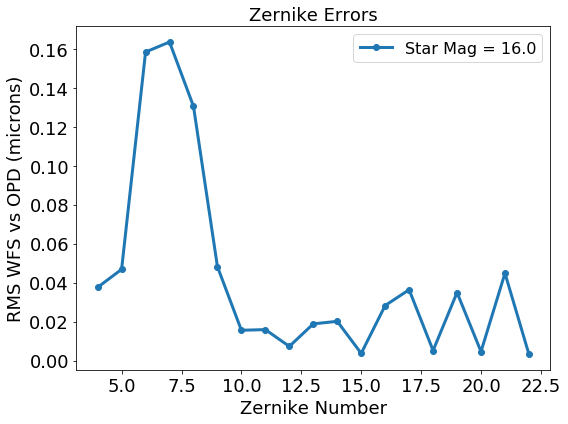

In [126]:
fig = plt.figure(figsize=(8,6))
mag_array = [magVal]
for i in range(len(mag_array)):
    plt.plot(np.arange(19)+4, np.sqrt(np.mean(np.square(zernikeErrors), axis=1)[:, i]), 
             '-o', lw=3, label='Star Mag = %.1f' % mag_array[i])
    plt.xlabel('Zernike Number', size=18)
    plt.ylabel('RMS WFS vs OPD (microns)', size=18)
    plt.xticks(size=18)
    plt.yticks(size=18)
plt.legend(fontsize=16)
plt.title('Zernike Errors', size=18)
    
plt.tight_layout()

This picture from https://www.janssenprecisionengineering.com/wp-content/uploads/Zernike_modes_adapted.png illustrates which optical distortions these Zernikes correspond: 
    <img src='Zernike_modes_adapted.png'></img>

[continue baseComcamLoop](#continue)

debug line 236 of baseComcamLoop:  

`listOfWfErr = wepCalc.calculateWavefrontErrors(
    intraRawExpData, extraRawExpData=extraRawExpData)
    `

Code from https://github.com/lsst-ts/ts_wep/blob/master/python/lsst/ts/wep/ctrlIntf/WEPCalculation.py :

In [29]:
import os
import warnings

from lsst.ts.wep.Utility import getModulePath, getConfigDir, BscDbType, \
    FilterType, abbrevDectectorName, getBscDbType, getImageType, \
    getCentroidFindType, ImageType
from lsst.ts.wep.CamDataCollector import CamDataCollector
from lsst.ts.wep.CamIsrWrapper import CamIsrWrapper
from lsst.ts.wep.SourceProcessor import SourceProcessor
from lsst.ts.wep.SourceSelector import SourceSelector
from lsst.ts.wep.WfEstimator import WfEstimator
from lsst.ts.wep.WepController import WepController
from lsst.ts.wep.ctrlIntf.SensorWavefrontData import SensorWavefrontData
from lsst.ts.wep.ParamReader import ParamReader
from lsst.ts.wep.ctrlIntf.MapSensorNameAndId import MapSensorNameAndId


In [30]:
rawExpData = intraRawExpData
extraRawExpData=extraRawExpData

In [33]:
if (extraRawExpData is None):
        raise ValueError("Corner WFS is not supported yet.")

if (len(rawExpData.getVisit()) != 1):
    raise ValueError("Only single visit is allowed at this time.")

In [35]:
#When evaluating the eimage, the calibration products are not needed.
# Therefore, need to make sure the camera mapper file exists.
wepCalc._genCamMapperIfNeed()

# Ingest the exposure data and do the ISR
wepCalc._ingestImg(rawExpData)
if (extraRawExpData is not None):
    wepCalc._ingestImg(extraRawExpData)

# Only the amplifier image needs to do the ISR
imgType = wepCalc._getImageType()
if (imgType == ImageType.Amp):
    wepCalc._doIsr(isrConfigfileName="isr_config.py")

In [36]:
# Set the butler inputs path to get the images
butlerRootPath = wepCalc._getButlerRootPath()
wepCalc.wepCntlr.setPostIsrCcdInputs(butlerRootPath)


In [37]:
# Get the target stars map neighboring stars
neighborStarMap = wepCalc._getTargetStar()

ValueError: StarTableG exists in database already.

INSIDE `wepCalc._getTargetStar()`:

In [64]:
#part of _prepareWepCalc()
wepCalc = WEPCalculationFactory.getCalculator(CamType.ComCam, isrDirPath)
wepCalc.setFilter(filterType)
wepCalc.setBoresight(raInDeg, decInDeg)
wepCalc.setRotAng(rotAngInDeg)

In [61]:
sourSelc = wepCalc.wepCntlr.getSourSelc()


<BscDbType.LocalDbForStarFile: 2>

In [65]:
# Connect the database
sourSelc = wepCalc.wepCntlr.getSourSelc()
bscDbType = wepCalc._getBscDbType()
if bscDbType in (BscDbType.LocalDb, BscDbType.LocalDbForStarFile):
    dbRelativePath = wepCalc.settingFile.getSetting("defaultBscPath")
    dbAdress = os.path.join(getModulePath(), dbRelativePath)
    sourSelc.connect(dbAdress)
else:
    raise ValueError("WEPCalculation does not support %s yet." % bscDbType)

In [66]:
sourSelc.db.getAllId(FilterType.fromString("g"))

OperationalError: no such table: StarTableG

In [40]:
# Do the query
sourSelc.setObsMetaData(wepCalc.raInDeg, wepCalc.decInDeg, wepCalc.rotSkyPos)

camDimOffset = wepCalc.settingFile.getSetting("camDimOffset")

In [41]:
if (bscDbType == BscDbType.LocalDb):
    neighborStarMap = sourSelc.getTargetStar(offset=camDimOffset)[0]
    
elif (bscDbType == BscDbType.LocalDbForStarFile):
    skyFile = wepCalc._assignSkyFile()
    neighborStarMap = sourSelc.getTargetStarByFile(skyFile, offset=camDimOffset)[0]

ValueError: StarTableG exists in database already.

INSIDE `sourSelc.getTargetStarByFile(`:

In [43]:
from lsst.ts.wep.bsc.Filter import Filter
from lsst.ts.wep.bsc.CamFactory import CamFactory
from lsst.ts.wep.bsc.DatabaseFactory import DatabaseFactory
from lsst.ts.wep.bsc.LocalDatabaseForStarFile import LocalDatabaseForStarFile
from lsst.ts.wep.Utility import mapFilterRefToG, getConfigDir
from lsst.ts.wep.ParamReader import ParamReader

if (not isinstance(sourSelc.db, LocalDatabaseForStarFile)):
    raise TypeError("The database type is incorrect.")

# Map the reference filter to the G filter
filterType = sourSelc.getFilter()
mappedFilterType = mapFilterRefToG(filterType)

In [63]:
# Delete the table
sourSelc.db.deleteTable(mappedFilterType)



## begin Debugging code 

The error I encountered last time pertains to this line  : l.237 in `baseComcamLoop.py` .... 

File "runStarSeparationAnalysis.py", line 77, in <module>
    inputSkyFilePath=skyFilePath, m1m3ForceError=0.05)
  File "/data/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/baseComcamLoop.py", line 237, in main
    intraRawExpData, extraRawExpData=extraRawExpData)
  File "/astro/store/epyc/projects/lsst_comm/ts_wep/python/lsst/ts/wep/ctrlIntf/WEPCalculation.py", line 391, in calculateWavefrontErrors
    donutMap = self._calcWfErr(neighborStarMap, obsIdList)
  File "/astro/store/epyc/projects/lsst_comm/ts_wep/python/lsst/ts/wep/ctrlIntf/WEPCalculation.py", line 598, in _calcWfErr
    doDeblending=doDeblending)
  File "/astro/store/epyc/projects/lsst_comm/ts_wep/python/lsst/ts/wep/WepController.py", line 371, in getDonutMap
    np.savetxt('/astro/store/epyc/projects/lsst_comm/ts_phosim/notebooks/analysis_scripts/example.out', singleSciNeiImg)
  File "/astro/store/epyc/projects/lsst_comm/new_stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/lib/npyio.py", line 1352, in savetxt
    open(fname, 'wt').close()
PermissionError: [Errno 13] Permission denied: '/astro/store/epyc/projects/lsst_comm/ts_phosim/notebooks/analysis_scripts/example.out'

In [58]:
from lsst.ts.wep.Utility import getModulePath, getConfigDir, BscDbType, \
    FilterType, abbrevDectectorName, getBscDbType, getImageType, \
    getCentroidFindType, ImageType

In [84]:
# this is wepCalc._getTargetStar()
# Connect the database
sourSelc = wepCalc.wepCntlr.getSourSelc()
bscDbType = wepCalc._getBscDbType()

In [85]:

if bscDbType in (BscDbType.LocalDb, BscDbType.LocalDbForStarFile):
    dbRelativePath = wepCalc.settingFile.getSetting("defaultBscPath")
    dbAdress = os.path.join(getModulePath(), dbRelativePath)
    sourSelc.connect(dbAdress)
else:
    raise ValueError("WEPCalculation does not support %s yet." % bscDbType)

# Do the query
sourSelc.setObsMetaData(wepCalc.raInDeg, wepCalc.decInDeg, wepCalc.rotSkyPos)


In [86]:

camDimOffset = wepCalc.settingFile.getSetting("camDimOffset")
if (bscDbType == BscDbType.LocalDb):
    neighborStarMap = sourSelc.getTargetStar(offset=camDimOffset)[0]
    
elif (bscDbType == BscDbType.LocalDbForStarFile):
    skyFile = wepCalc._assignSkyFile()
    
    #neighborStarMap = sourSelc.getTargetStarByFile(
    #    skyFile, offset=camDimOffset)



In [89]:
from lsst.ts.wep.bsc.LocalDatabaseForStarFile import LocalDatabaseForStarFile
from lsst.ts.wep.Utility import mapFilterRefToG, getConfigDir
# check  ts_wep  SourceSelector.getTargetStarByFile
## begin ts_wep.SourceSelector.getTargetStarByFile()
if (not isinstance(sourSelc.db, LocalDatabaseForStarFile)):
    raise TypeError("The database type is incorrect.")

offset=camDimOffset
    
# Map the reference filter to the G filter
filterType = sourSelc.getFilter()
mappedFilterType = mapFilterRefToG(filterType)

# Delete the table
sourSelc.db.deleteTable(mappedFilterType)

# Write the sky data into the temporary table
sourSelc.db.createTable(mappedFilterType)


In [90]:
sourSelc.db.insertDataByFile(skyFilePath, mappedFilterType, skiprows=1)
neighborStarMap, starMap, wavefrontSensors = sourSelc.getTargetStar(offset=offset)



In [116]:
cursor = sourSelc.db.connection.cursor()

In [122]:
sourSelc.db.getAllId(filterType)

OperationalError: no such table: StarTableREF

In [117]:
sourSelc.db._getTableName(filterType)

'StarTableREF'

In [123]:
query  = "SELECT * FROM StarTableG"

In [124]:
cursor.execute(query)

In [126]:
cursor.fetchall()

[(1, 0, 359.765411, -0.259589, 17.5, 0),
 (2, 1, 359.765411, -0.209589, 17.5, 0),
 (3, 2, 359.765411, -0.024889, 17.5, 0),
 (4, 3, 359.765411, 0.025111, 17.5, 0),
 (5, 4, 359.765411, 0.209811, 17.5, 0),
 (6, 5, 359.765411, 0.259811, 17.5, 0),
 (7, 6, 0.000111, -0.259589, 17.5, 0),
 (8, 7, 0.000111, -0.209589, 17.5, 0),
 (9, 8, 0.000111, -0.024889, 17.5, 0),
 (10, 9, 0.000111, 0.025111, 17.5, 0),
 (11, 10, 0.000111, 0.209811, 17.5, 0),
 (12, 11, 0.000111, 0.259811, 17.5, 0),
 (13, 12, 0.234811, -0.259589, 17.5, 0),
 (14, 13, 0.234811, -0.209589, 17.5, 0),
 (15, 14, 0.234811, -0.024889, 17.5, 0),
 (16, 15, 0.234811, 0.025111, 17.5, 0),
 (17, 16, 0.234811, 0.209811, 17.5, 0),
 (18, 17, 0.234811, 0.259811, 17.5, 0)]

OperationalError: no such table: StarTableREF

In [100]:
sourSelc.db.query("SELECT * FROM gStarTable")

TypeError: query() missing 4 required positional arguments: 'corner1', 'corner2', 'corner3', and 'corner4'

In [ ]:
# Delete the table
sourSelc.db.deleteTable(mappedFilterType)


# Disconnect the database
sourSelc.disconnect()




In [65]:
!more /epyc/users/suberlak/Commissioning/aos/aoclc_output/iter0/pert/skyComCamInfo.txt

# Id	 Ra		 Decl		 Mag
0	 359.765411	 -0.259589	 17.500000
1	 359.765411	 -0.209589	 17.500000
2	 359.765411	 -0.024889	 17.500000
3	 359.765411	 0.025111	 17.500000
4	 359.765411	 0.209811	 17.500000
5	 359.765411	 0.259811	 17.500000
6	 0.000111	 -0.259589	 17.500000
7	 0.000111	 -0.209589	 17.500000
8	 0.000111	 -0.024889	 17.500000
9	 0.000111	 0.025111	 17.500000
10	 0.000111	 0.209811	 17.500000
11	 0.000111	 0.259811	 17.500000
12	 0.234811	 -0.259589	 17.500000
13	 0.234811	 -0.209589	 17.500000
14	 0.234811	 -0.024889	 17.500000
15	 0.234811	 0.025111	 17.500000
16	 0.234811	 0.209811	 17.500000
17	 0.234811	 0.259811	 17.500000


In [48]:
# Calculate the wavefront error
intraObsIdList = intraRawExpData.getVisit()
intraObsId = intraObsIdList[0]
if (extraRawExpData is None):
    obsIdList = [intraObsId]
else:
    extraObsIdList = extraRawExpData.getVisit()
    extraObsId = extraObsIdList[0]
    obsIdList = [intraObsId, extraObsId]

donutMap = wepCalc._calcWfErr(neighborStarMap, obsIdList)
listOfWfErr = wepCalc._populateListOfSensorWavefrontData(donutMap)

In [52]:
neighborStarMap

{}

In [26]:
# Calculate the wavefront error and DOF
listOfWfErr = wepCalc.calculateWavefrontErrors(intraRawExpData, extraRawExpData=extraRawExpData)
ofcCalc.calculateCorrections(listOfWfErr)

IndexError: list index out of range

## end Debugging code 
<a href='continue'></a>